In [1]:
# Cellule 1 — Imports, config, chargement des données et du modèle

RANDOM_STATE = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix
)
import joblib

pd.set_option("display.max_columns", None)

print("OK imports.")

# Chargement du CSV NHANES complet
df = pd.read_csv("nhanes_ready.csv")
print("Shape df :", df.shape)
df.head(3)

# Chargement du modèle cholestérol et du scaler (issus du notebook 12)
model = joblib.load("artifacts_chol_no_bias/model_lightgbm_chol_no_bias.pkl")
scaler = joblib.load("artifacts_chol_no_bias/scaler_chol_no_bias.pkl")

print("Modèle et scaler chargés.")


OK imports.
Shape df : (6889, 38)
Modèle et scaler chargés.


In [2]:
# Cellule 2 — Définition des features (identique au modèle 12)

USE_ETHNICITY = True
target = "chol_high"

core = ["RIDAGEYR", "RIAGENDR", "smoker"]
morpho = ["BMXBMI_log", "BMXWAIST"]
lifestyle = ["PAD680_log", "SLD012"]

ethn = [
    "ethnicity_MexicanAmerican", "ethnicity_OtherHispanic",
    "ethnicity_NonHispanicWhite", "ethnicity_NonHispanicBlack",
    "ethnicity_NonHispanicAsian", "ethnicity_OtherRace"
]

if USE_ETHNICITY:
    candidate_feats = core + morpho + lifestyle + ethn
else:
    candidate_feats = core + morpho + lifestyle

features = [c for c in candidate_feats if c in df.columns]
missing = [c for c in candidate_feats if c not in df.columns]
if missing:
    print("Colonnes absentes (ignorées) :", missing)

X_full = df[features].copy()
y = df[target].astype(int)

print(f"X_full : {X_full.shape} | y pos rate : {y.mean():.3f}")
print("Features utilisées :", features)


X_full : (6889, 13) | y pos rate : 0.090
Features utilisées : ['RIDAGEYR', 'RIAGENDR', 'smoker', 'BMXBMI_log', 'BMXWAIST', 'PAD680_log', 'SLD012', 'ethnicity_MexicanAmerican', 'ethnicity_OtherHispanic', 'ethnicity_NonHispanicWhite', 'ethnicity_NonHispanicBlack', 'ethnicity_NonHispanicAsian', 'ethnicity_OtherRace']


In [3]:
# Cellule 3 — Split stratifié train / val / test (comme dans le modèle 12)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25, stratify=y_train_full, random_state=RANDOM_STATE
)

print("=== Répartition ===")
print(f"Train : {len(X_train)} | Val : {len(X_val)} | Test : {len(X_test)}")
print("Taux pos — Train/Val/Test :",
      round(y_train.mean(), 3),
      round(y_val.mean(), 3),
      round(y_test.mean(), 3))


=== Répartition ===
Train : 4133 | Val : 1378 | Test : 1378
Taux pos — Train/Val/Test : 0.09 0.09 0.089


In [4]:
# Cellule 4 — Colonnes num/binaire + standardisation de X_test

binary_cols = ["RIAGENDR", "smoker"]
if USE_ETHNICITY:
    binary_cols += ethn

binary_cols = [c for c in binary_cols if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in binary_cols]

print(f"Colonnes binaires ({len(binary_cols)}) :", binary_cols)
print(f"Colonnes standardisées ({len(num_cols)}) :", num_cols)

# Standardisation de X_test avec le scaler du modèle 12
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

print("X_test_scaled OK. Shape :", X_test_scaled.shape)


Colonnes binaires (8) : ['RIAGENDR', 'smoker', 'ethnicity_MexicanAmerican', 'ethnicity_OtherHispanic', 'ethnicity_NonHispanicWhite', 'ethnicity_NonHispanicBlack', 'ethnicity_NonHispanicAsian', 'ethnicity_OtherRace']
Colonnes standardisées (5) : ['RIDAGEYR', 'BMXBMI_log', 'BMXWAIST', 'PAD680_log', 'SLD012']
X_test_scaled OK. Shape : (1378, 13)


In [5]:
# Cellule 5 — Prédictions au seuil 0.35 + rapport global

THRESHOLD = 0.35

y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_test_proba >= THRESHOLD).astype(int)

print(f"=== RAPPORT DE CLASSIFICATION (seuil {THRESHOLD}) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)


=== RAPPORT DE CLASSIFICATION (seuil 0.35) ===
              precision    recall  f1-score   support

           0      0.970     0.437     0.602      1255
           1      0.130     0.862     0.226       123

    accuracy                          0.475      1378
   macro avg      0.550     0.649     0.414      1378
weighted avg      0.895     0.475     0.569      1378

Matrice de confusion :
 [[548 707]
 [ 17 106]]


In [6]:
# Cellule 6 — DataFrame test complet avec LBXTC

df_test_full = X_test.copy()           # données NON standardisées pour l'interprétation
df_test_full["y_true"] = y_test.values
df_test_full["y_pred"] = y_pred
df_test_full["proba"] = y_test_proba

# Ajout de la colonne LBXTC à partir du df complet (même index)
df_test_full["LBXTC"] = df.loc[X_test.index, "LBXTC"]

df_test_full.head()


,RIDAGEYR,RIAGENDR,smoker,BMXBMI_log,BMXWAIST,PAD680_log,SLD012,ethnicity_MexicanAmerican,ethnicity_OtherHispanic,ethnicity_NonHispanicWhite,ethnicity_NonHispanicBlack,ethnicity_NonHispanicAsian,ethnicity_OtherRace,y_true,y_pred,proba,LBXTC
6411,35.0,2,0,3.777348,102.6,2.772589,10.5,False,False,False,False,False,True,0,1,0.435688,182.0
1350,18.0,1,0,3.182212,84.3,5.484797,4.0,True,False,False,False,False,False,0,0,0.085499,147.0
1171,32.0,2,0,3.384390,94.0,6.398595,8.5,False,True,False,False,False,False,0,0,0.213149,170.0
6502,77.0,2,1,3.549617,109.7,5.888878,8.0,False,False,True,False,False,False,0,1,0.406909,158.0
2855,43.0,2,1,3.161247,88.7,5.484797,8.5,False,False,True,False,False,False,0,1,0.584271,182.0


In [7]:
# Cellule 7 — Identification des faux négatifs et faux positifs

# Faux négatifs = vrais 1 mais prédits 0
FN_mask = (df_test_full["y_true"] == 1) & (df_test_full["y_pred"] == 0)

# Faux positifs = vrais 0 mais prédits 1
FP_mask = (df_test_full["y_true"] == 0) & (df_test_full["y_pred"] == 1)

df_FN = df_test_full[FN_mask].copy()
df_FP = df_test_full[FP_mask].copy()

print(f"Faux négatifs (FN) : {len(df_FN)}")
print(f"Faux positifs (FP) : {len(df_FP)}")


Faux négatifs (FN) : 17
Faux positifs (FP) : 707


In [8]:
# Cellule 8 — Statistiques descriptives ALL / FN / FP

stats_all = X_test.describe().T[["mean", "std"]]
stats_FN = df_FN[features].describe().T[["mean", "std", "min", "max"]]
stats_FP = df_FP[features].describe().T[["mean", "std", "min", "max"]]

df_compare = stats_all.copy()
df_compare = df_compare.rename(columns={"mean": "mean_all", "std": "std_all"})
df_compare["mean_FN"] = stats_FN["mean"]
df_compare["std_FN"]  = stats_FN["std"]
df_compare["mean_FP"] = stats_FP["mean"]
df_compare["std_FP"]  = stats_FP["std"]

df_compare


,mean_all,std_all,mean_FN,std_FN,mean_FP,std_FP
RIDAGEYR,45.346880,22.129647,38.705882,21.953829,55.504950,14.367335
RIAGENDR,1.555878,0.497048,1.764706,0.437237,1.589816,0.492215
smoker,0.346880,0.476150,0.117647,0.332106,0.444130,0.497221
BMXBMI_log,3.349647,0.252193,3.339318,0.238106,3.413133,0.231710
BMXWAIST,96.265022,18.796348,93.088235,16.293591,101.968458,16.714216
PAD680_log,5.726450,0.664109,5.436124,0.846929,5.737552,0.774125
SLD012,7.771771,1.445066,8.411765,1.760995,7.698020,1.531204


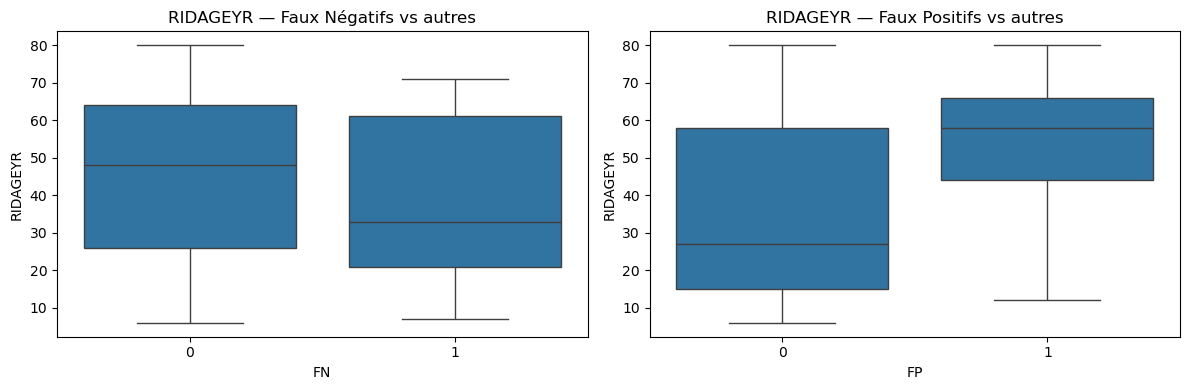

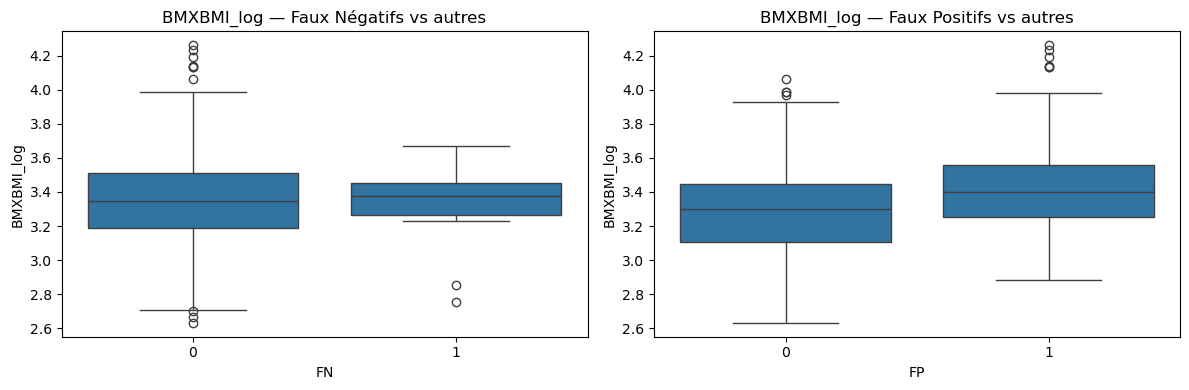

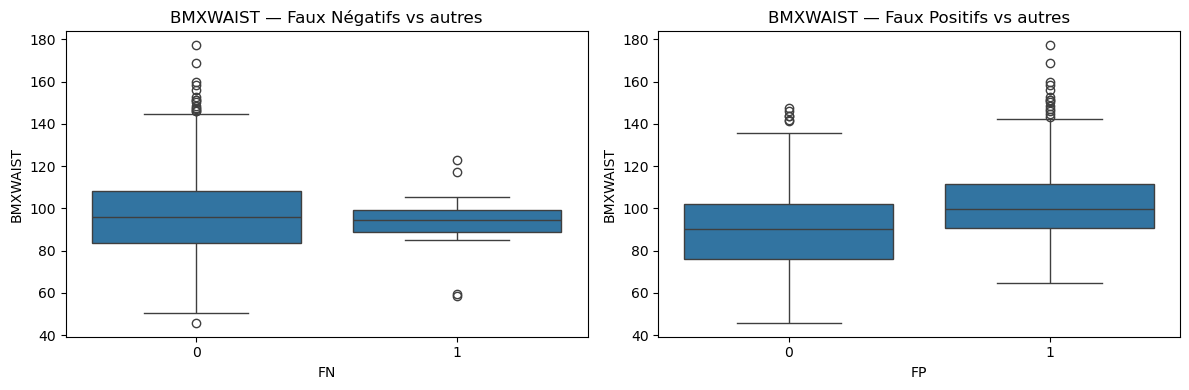

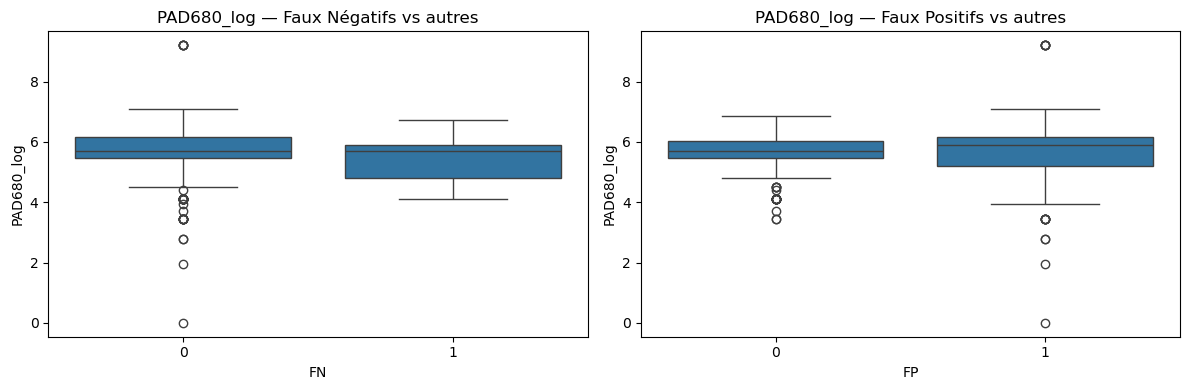

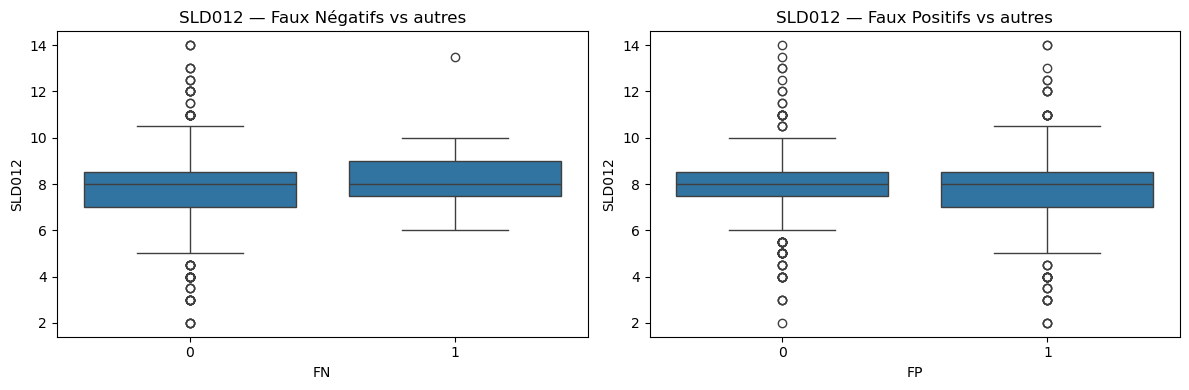

In [9]:
# Cellule 9 — Boxplots FN / FP vs autres pour les colonnes numériques

df_plot = X_test.copy()
df_plot["FN"] = FN_mask.astype(int)
df_plot["FP"] = FP_mask.astype(int)

for col in num_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.boxplot(data=df_plot, x="FN", y=col)
    plt.title(f"{col} — Faux Négatifs vs autres")

    plt.subplot(1,2,2)
    sns.boxplot(data=df_plot, x="FP", y=col)
    plt.title(f"{col} — Faux Positifs vs autres")

    plt.tight_layout()
    plt.show()


In [10]:
# Cellule 10 — Distribution des probabilités pour FN et FP

df_proba = df_test_full[["y_true", "y_pred", "proba"]].copy()
df_proba["FN"] = FN_mask.astype(int)
df_proba["FP"] = FP_mask.astype(int)

print("Résumé des probabilités pour les FN :")
print(df_proba[df_proba["FN"] == 1]["proba"].describe())

print("\nRésumé des probabilités pour les FP :")
print(df_proba[df_proba["FP"] == 1]["proba"].describe())


Résumé des probabilités pour les FN :
count    17.000000
mean      0.235829
std       0.084040
min       0.060149
25%       0.192711
50%       0.232724
75%       0.292871
max       0.340643
Name: proba, dtype: float64

Résumé des probabilités pour les FP :
count    707.000000
mean       0.560344
std        0.096795
min        0.350274
25%        0.491847
50%        0.568992
75%        0.639997
max        0.741910
Name: proba, dtype: float64


In [11]:
# Cellule 11 — Faux positifs dans la zone "grise" LBXTC 200–240 mg/dL

# Filtrage des FP
fp_all = df_FP.copy()

zone_normal = fp_all[fp_all["LBXTC"] < 200]
zone_grey   = fp_all[(fp_all["LBXTC"] >= 200) & (fp_all["LBXTC"] <= 240)]
zone_high   = fp_all[fp_all["LBXTC"] > 240]

total_fp = len(fp_all)

print(f"Faux positifs totaux (seuil {THRESHOLD}) : {total_fp}\n")

print(f"Zone <200 mg/dL     : {len(zone_normal)}  ({len(zone_normal)/total_fp*100:.1f} %)")
print(f"Zone 200–240 mg/dL  : {len(zone_grey)}   ({len(zone_grey)/total_fp*100:.1f} %)")
print(f"Zone >240 mg/dL     : {len(zone_high)}   ({len(zone_high)/total_fp*100:.1f} %)\n")

# Stats descriptives dans la zone grise
print("Statistiques LBXTC pour les FP en zone 200–240 :")
display(zone_grey["LBXTC"].describe().round(1))

zone_grey.head()


Faux positifs totaux (seuil 0.35) : 707

Zone <200 mg/dL     : 503  (71.1 %)
Zone 200–240 mg/dL  : 204   (28.9 %)
Zone >240 mg/dL     : 0   (0.0 %)

Statistiques LBXTC pour les FP en zone 200–240 :


count    204.0
mean     215.9
std       11.5
min      200.0
25%      206.0
50%      214.0
75%      226.0
max      240.0
Name: LBXTC, dtype: float64

,RIDAGEYR,RIAGENDR,smoker,BMXBMI_log,BMXWAIST,PAD680_log,SLD012,ethnicity_MexicanAmerican,ethnicity_OtherHispanic,ethnicity_NonHispanicWhite,ethnicity_NonHispanicBlack,ethnicity_NonHispanicAsian,ethnicity_OtherRace,y_true,y_pred,proba,LBXTC
1677,57.0,2,0,3.468856,106.2,5.707110,6.0,True,False,False,False,False,False,0,1,0.382791,205.0
3606,65.0,1,0,3.446808,107.0,5.707110,7.5,False,False,True,False,False,False,0,1,0.548249,202.0
3123,42.0,1,0,3.660994,117.6,5.198497,6.5,False,True,False,False,False,False,0,1,0.593799,238.0
5365,62.0,1,1,3.261935,87.8,4.795791,9.5,False,False,False,False,True,False,0,1,0.539061,205.0
2239,61.0,2,0,3.885679,95.8,6.175867,8.0,False,False,True,False,False,False,0,1,0.590778,202.0


In [12]:
# Cellule 12 : nb de FP qui sont des femmes, d'au moins 55 ans,
# avec IMC et tour de taille eleves

# --- Définition des seuils ---
age_threshold = 55
bmi_threshold = 30      # IMC élevé (OMS)
waist_threshold = 88    # Tour de taille élevé femme (OMS)

# --- Reconstruction de l'IMC si nécessaire ---
if "BMXBMI" in df_FP.columns:
    df_FP["BMI"] = df_FP["BMXBMI"]
else:
    # Si on n'a que BMXBMI_log
    df_FP["BMI"] = np.exp(df_FP["BMXBMI_log"])

# --- Conditions ---
cond_femme = df_FP["RIAGENDR"] == 2
cond_age   = df_FP["RIDAGEYR"] >= age_threshold
cond_bmi   = df_FP["BMI"] >= bmi_threshold
cond_waist = df_FP["BMXWAIST"] >= waist_threshold

# --- Sous-ensemble correspondant ---
df_FP_femmes_55_IMC_taille = df_FP[
    cond_femme & cond_age & cond_bmi & cond_waist
]

# --- Résultats ---
n_FP = len(df_FP)
n_FP_crit = len(df_FP_femmes_55_IMC_taille)
ratio = (n_FP_crit / n_FP) * 100 if n_FP > 0 else 0

print(f"Nombre total de faux positifs : {n_FP}")
print(f"Faux positifs femmes ≥55 ans avec IMC élevé + tour de taille élevé : {n_FP_crit}")
print(f"Proportion : {ratio:.1f}%")

df_FP_femmes_55_IMC_taille.head()


Nombre total de faux positifs : 707
Faux positifs femmes ≥55 ans avec IMC élevé + tour de taille élevé : 126
Proportion : 17.8%


,RIDAGEYR,RIAGENDR,smoker,BMXBMI_log,BMXWAIST,PAD680_log,SLD012,ethnicity_MexicanAmerican,ethnicity_OtherHispanic,ethnicity_NonHispanicWhite,ethnicity_NonHispanicBlack,ethnicity_NonHispanicAsian,ethnicity_OtherRace,y_true,y_pred,proba,LBXTC,BMI
6502,77.0,2,1,3.549617,109.7,5.888878,8.0,False,False,True,False,False,False,0,1,0.406909,158.0,34.8
4020,64.0,2,0,3.496508,120.5,5.198497,7.5,False,False,True,False,False,False,0,1,0.660960,127.0,33.0
3775,68.0,2,0,3.437208,95.9,6.175867,9.5,False,False,True,False,False,False,0,1,0.675786,194.0,31.1
1677,57.0,2,0,3.468856,106.2,5.707110,6.0,True,False,False,False,False,False,0,1,0.382791,205.0,32.1
4886,65.0,2,0,3.676301,106.9,5.484797,8.0,False,False,True,False,False,False,0,1,0.626403,180.0,39.5


In [13]:
# Cellule 13 : nb de FP qui sont soit des  femmes d'au moins 55 ans avec IMC 
# et tour de taille eleves , soit dans la zone grise 200-240 

# --- Seuils médicaux ---
age_threshold = 55
bmi_threshold = 30      # IMC élevé (OMS)
waist_threshold = 88    # Tour de taille élevé femme (OMS)
zone_lo = 200           # cholestérol zone grise
zone_hi = 240

# --- Reconstruction IMC si nécessaire ---
if "BMXBMI" in df_FP.columns:
    df_FP["BMI"] = df_FP["BMXBMI"]
else:
    df_FP["BMI"] = np.exp(df_FP["BMXBMI_log"])

# --- Profil A : femmes ≥ 55 ans + IMC élevé + tour de taille élevé ---
cond_A = (
    (df_FP["RIAGENDR"] == 2) & 
    (df_FP["RIDAGEYR"] >= age_threshold) &
    (df_FP["BMI"] >= bmi_threshold) &
    (df_FP["BMXWAIST"] >= waist_threshold)
)

# --- Profil B : cholestérol dans la zone grise 200–240 ---
cond_B = (df_FP["LBXTC"] >= zone_lo) & (df_FP["LBXTC"] <= zone_hi)

# --- Union A ∪ B ---
df_FP_union = df_FP[cond_A | cond_B]

# --- Compte ---
n_total_FP = len(df_FP)
n_union = len(df_FP_union)
ratio = (n_union / n_total_FP) * 100 if n_total_FP > 0 else 0

print(f"Nombre total de faux positifs : {n_total_FP}")
print(f"Faux positifs correspondant à A OU B : {n_union}")
print(f"Proportion : {ratio:.1f}%")

df_FP_union.head()


Nombre total de faux positifs : 707
Faux positifs correspondant à A OU B : 292
Proportion : 41.3%


,RIDAGEYR,RIAGENDR,smoker,BMXBMI_log,BMXWAIST,PAD680_log,SLD012,ethnicity_MexicanAmerican,ethnicity_OtherHispanic,ethnicity_NonHispanicWhite,ethnicity_NonHispanicBlack,ethnicity_NonHispanicAsian,ethnicity_OtherRace,y_true,y_pred,proba,LBXTC,BMI
6502,77.0,2,1,3.549617,109.7,5.888878,8.0,False,False,True,False,False,False,0,1,0.406909,158.0,34.8
4020,64.0,2,0,3.496508,120.5,5.198497,7.5,False,False,True,False,False,False,0,1,0.660960,127.0,33.0
3775,68.0,2,0,3.437208,95.9,6.175867,9.5,False,False,True,False,False,False,0,1,0.675786,194.0,31.1
1677,57.0,2,0,3.468856,106.2,5.707110,6.0,True,False,False,False,False,False,0,1,0.382791,205.0,32.1
4886,65.0,2,0,3.676301,106.9,5.484797,8.0,False,False,True,False,False,False,0,1,0.626403,180.0,39.5
